In [1]:
%matplotlib inline

## Настройка классификатора изображений

Этапы решения задачи:

1. Загрузка и нормализация датасета CIFAR10
2. Описание сверточной нейронной сети
3. Описание функции потерь
4. Тренировка нейронной сети на части датасета
5. Проверка сети на тестовой выборке

### 1. Загрузка и нормализация датасета CIFAR10

Используется ``torchvision``

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Покажем некоторые элементы выборки.



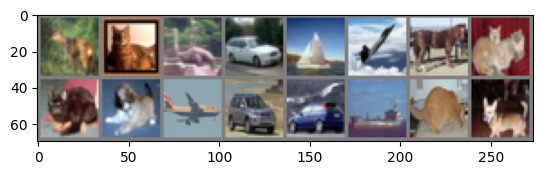

deer  cat   bird  car   ship  plane horse cat   cat   dog   plane car   car   ship  cat   dog  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# функция для отображениия рисунка


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Получили случайные элементы выборки
dataiter = iter(trainloader)
images, labels = next(dataiter)

# показали изображения
imshow(torchvision.utils.make_grid(images))
# напечатали подписи
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Описание сверточной нейронной сети
Скопировали нейронную сеть из модуля Neural Networks и указали, что она принимает 3-канальное изображение



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 180)
        self.fc3 = nn.Linear(180, 120)
        self.fc4 = nn.Linear(120, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.selu(self.conv1(x)))
        x = self.pool(F.selu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = F.selu(self.fc4(x))
        x = self.fc5(x)
        return x


net = Net()

### 3. Описание функции потерь
В качестве функции потерь используем кросс-энтропию и в качестве алгоритма оптимизации - стохастический градиентный спуск.



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Тренировка нейронной сети на части датасета



In [7]:
for epoch in range(10):  # Проходим по датасету несколько раз

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # получаем исходные данные в виде [inputs, labels]
        inputs, labels = data

        # обнуляем градиент параметров
        optimizer.zero_grad()

        # оптимизация
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # печатаем статистику
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.805
[2,  2000] loss: 1.392


Можно сохранить модель



In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

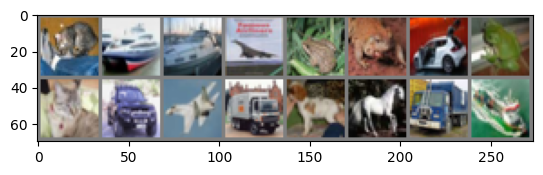

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Загрузим сохраненную сеть


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Проверяем, как работает настроенная сеть:

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   plane


Проверяем работу сети на всем датасете



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 65 %


Проверяем отдельно на каждом классе



In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 70.1 %
Accuracy for class: car   is 84.3 %
Accuracy for class: bird  is 53.0 %
Accuracy for class: cat   is 48.8 %
Accuracy for class: deer  is 51.8 %
Accuracy for class: dog   is 57.9 %
Accuracy for class: frog  is 70.6 %
Accuracy for class: horse is 75.5 %
Accuracy for class: ship  is 76.9 %
Accuracy for class: truck is 70.1 %
